In [1]:
# run in R4.3
# from 02d_structure_annote.protein_str_covg.ipynb

In [2]:
library(Hmisc)
library(GGally)
# library(DescTools)
library("FactoMineR")
library("factoextra")
library(mvtnorm)
library(umap)
library(grid)
library(gridExtra)
library(dplyr)
library(umap)


In [3]:
setwd('C:/Users/benja/bpk Dropbox/Benjamin Kellman/working_dir/projects/GTspecificity/')

# Load data

In [5]:
setwd("annotation/02_structure_annot")

out = lapply( ls<-list.files(pattern='GTspec.*.just_glyco.csv') , read.csv)
names(out) = sapply(strsplit(ls,'_'),function(x) x[2])
# names(out)
# str(out)

setwd('C:/Users/benja/bpk Dropbox/Benjamin Kellman/working_dir/projects/GTspecificity/')

name,unq_genes,unq_genes_with_str,unq_sites,unq_sites_with_str
<chr>,<chr>,<chr>,<chr>,<chr>
ADDITIONAL,5,5,54,54
ADDITIONALcorona,3,2,51,28
FLU,100,90,754,692
HIV,1,1,28,28
HLA,10442,9,10442,9
pdb,4652,1274,17099,3661
SARSCoV2Spike,321,161,5309,2673
SARSCoV2SpikeZhang,321,82,5308,1364
SECRETOME,576,565,2351,2224


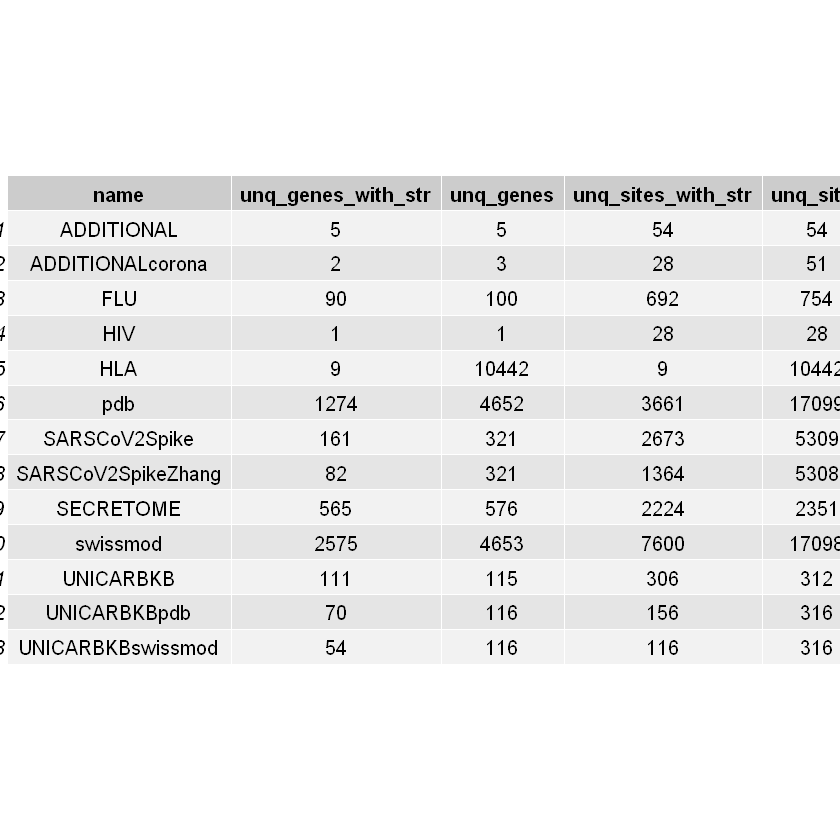

In [6]:
l=data.frame(do.call(rbind,lapply( names(out) , function(xn) {
	x = out[[xn]]
	c(name=xn,
	unq_genes = length(unique(x$gene_id)),
	unq_genes_with_str = length(unique(x$gene_id[with_str<-!is.na(x$struct_resnum)])),
	unq_sites = sum(table(x$gene_id,x$seq_resnum)),
	unq_sites_with_str = sum(table(x$gene_id[with_str],x$seq_resnum[with_str])))
})))
l

grid.table(l[,c(1,3,2,5,4)])

In [7]:
str(l)

'data.frame':	13 obs. of  5 variables:
 $ name              : chr  "ADDITIONAL" "ADDITIONALcorona" "FLU" "HIV" ...
 $ unq_genes         : chr  "5" "3" "100" "1" ...
 $ unq_genes_with_str: chr  "5" "2" "90" "1" ...
 $ unq_sites         : chr  "54" "51" "754" "28" ...
 $ unq_sites_with_str: chr  "54" "28" "692" "28" ...


# Factor Analysis on Mixed Data
To assess coverage of protein structure space

In [11]:
# colnames(out[['UNICARBKB']])[idx]

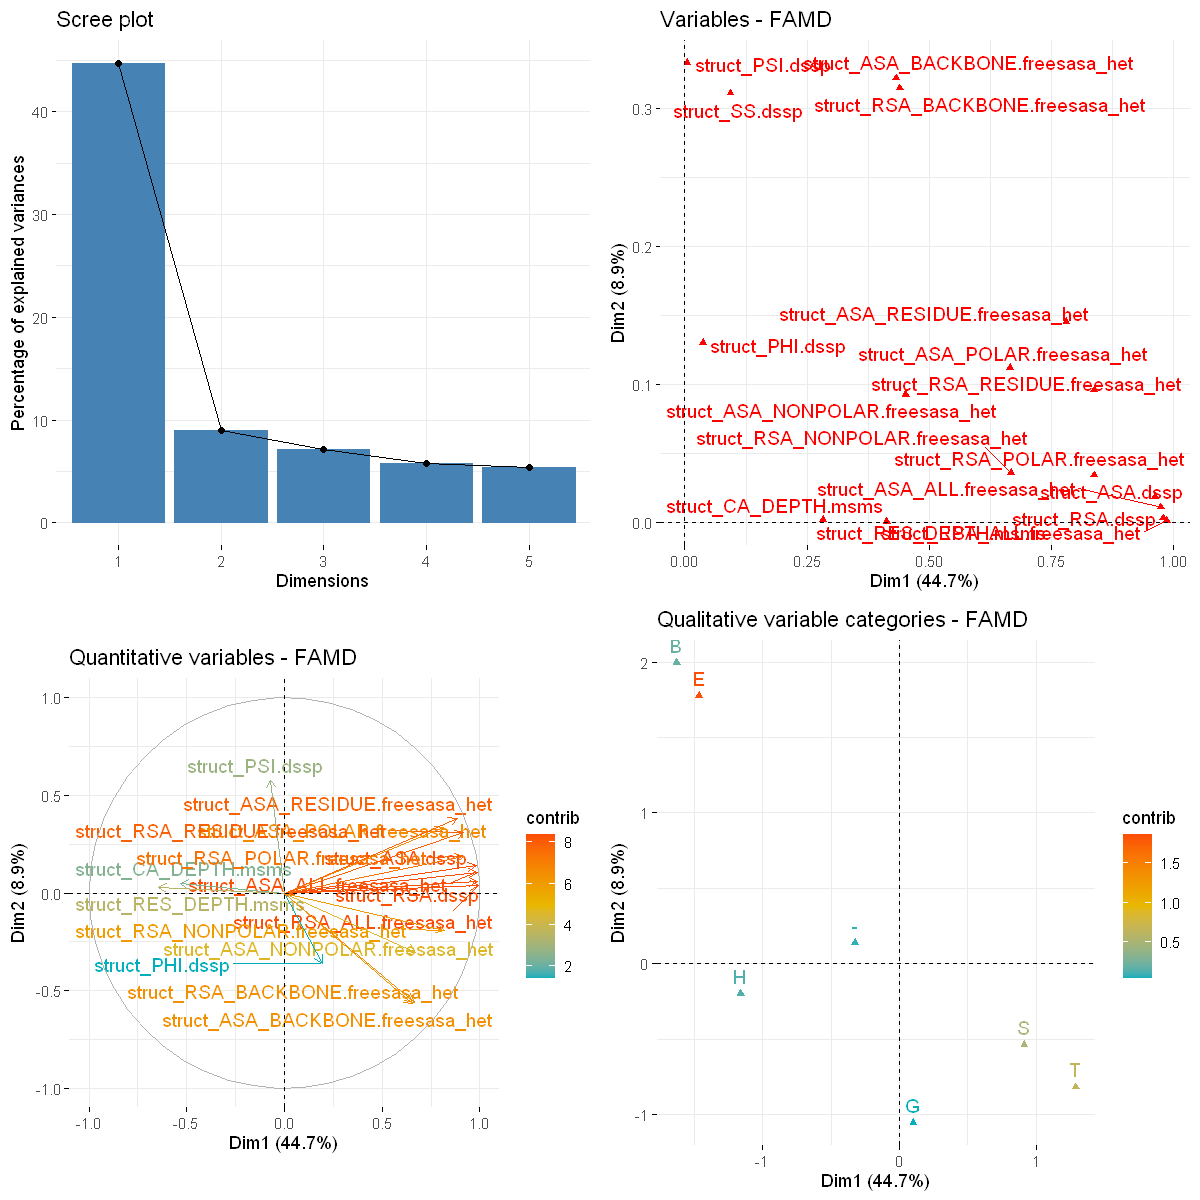

In [8]:
## model build and characterization
idx_name<-colnames(out[['UNICARBKB']])[idx<-(grepl('\\.',colnames(out[[1]]))&grepl('struct_',colnames(out[['UNICARBKB']])))]
mod = FAMD(dat_i<-na.omit(out[['UNICARBKB']][c(idx_name)]),graph=F)

# factor analysis QC
g1=fviz_screeplot(mod)
g2=fviz_famd_var(mod, repel = TRUE)
# quantitative variabel contribution
g3=fviz_famd_var(mod, "quanti.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE)
# qualitative variable contribution
g4=fviz_famd_var(mod, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")
             )

options(repr.plot.height=10,repr.plot.width=10)
cowplot::plot_grid(g1,g2,g3,g4)
ggsave('figures/database_coverage/02d_FAMD.pdf',width=15,heigh=15)

In [9]:
mod$eig
predi = c('UNICARBKB','UNICARBKBpdb','UNICARBKBswissmod','pdb','swissmod','FLU','HIV')
df=na.omit(do.call(rbind,tmp<-lapply(predi,function(x){
    print(x)
    dat_i = out[[x]][,idx]
    dat_i[dat_i$struct_SS.dssp=='I',]=NA
    dat_i=droplevels(na.omit(dat_i))
	tmp=predict(mod,dat_i)
    if('na.action'%in%names(attributes(dat_i))){
        idx_i = -attr(dat_i,'na.action')
    }else{ idx_i=1:nrow(out[[x]]) }
	data.frame(data=x  , tmp$coord, glycosite = out[[x]]$seq_residue[idx_i] )	
#	data.frame(data=x,mod$eig %*% tmp$coord )	
})))

head(df)

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,9.838391,44.719958,44.71996
comp 2,1.968964,8.949836,53.66979
comp 3,1.580286,7.183117,60.85291
comp 4,1.267365,5.760748,66.61366
comp 5,1.197424,5.442835,72.05649


[1] "UNICARBKB"
[1] "UNICARBKBpdb"
[1] "UNICARBKBswissmod"
[1] "pdb"
[1] "swissmod"
[1] "FLU"
[1] "HIV"


,data,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,glycosite
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
176,UNICARBKB,-2.4000446,0.7940771,0.27270916,-0.1364262,-0.03720138,N
29,UNICARBKB,0.7797281,0.4238156,-1.33377298,-0.1047140,-0.18230064,N
313,UNICARBKB,5.9928102,0.2194493,-0.12952913,-0.7888679,0.81339384,N
410,UNICARBKB,-2.5330312,0.8149003,-0.09450988,-1.2492785,-1.00307026,N
510,UNICARBKB,-2.2083498,-1.3667727,0.60008149,-0.5218520,-0.83902370,T
610,UNICARBKB,2.2746154,0.5458659,1.17994475,-0.3465660,-0.84669761,N


In [10]:
df=df %>% 
    mutate( data = factor(data,levels=c('UNICARBKB','UNICARBKBpdb','UNICARBKBswissmod','pdb','swissmod','FLU','HIV')))

In [13]:

# p_l=apply(na.omit(df[,2:3]),1,function(x){
# 	pmvnorm(lower=-Inf, upper=x, mean=c(0,0), #colMeans(df[df$data=='UNICARBKB',2:3]),
#         corr=NULL, sigma=cov(df[df$data=='UNICARBKB',2:3])) })
# p_h=apply(na.omit(df[,2:3]),1,function(x){
# 	pmvnorm(lower=x, upper=Inf, mean=c(0,0), #colMeans(df[df$data=='UNICARBKB',2:3]),
#         corr=NULL, sigma=cov(df[df$data=='UNICARBKB',2:3])) })


In [14]:
# head(cbind(p_l,p_h))

In [15]:
# hist(df$p<-apply(cbind(p_l,p_h),1,function(x) min(x)*2)+1e-100,main='p-value for multivariate gaussian distribution\nover dim1 and 2 of FAMD')
# hist(df$q<-p.adjust(df$p,'fdr'),main='FDR for multivariate gaussian distribution over\ndim1 and 2 of FAMD')

# ggplot(df,aes(x=q,fill=data))+geom_histogram(bins=100)+#scale_y_log10()+
#                  geom_vline(xintercept=.1)+theme_classic()+
#                  ggtitle('FDR for multivariate gaussian distribution over\ndim1 and 2 of FAMD')
# ggsave('figures/database_coverage/02d_FAMD.fdr.split.pdf',width=10,height=10)

# ggplot(df,aes(x=q))+geom_histogram(bins=100)+scale_y_log10()+
#                  geom_vline(xintercept=.1)+theme_classic(base_size = 20)+
#                  ggtitle('FDR for multivariate gaussian distribution over\ndim1 and 2 of FAMD')
# ggsave('figures/database_coverage/02d_FAMD.fdr.pdf',width=10,height=10)


In [16]:
# # str(df)
# table(df$q<.1,df[,1])

In [17]:

# grid.table(data.frame(table(df[,1],df$q<.1)))

# Visualization and 2d-gaussian with UMAP

In [20]:


idy=grepl('Dim',colnames(df))
idx=apply(df[,idy],1,function(x) all(is.finite(x)))

mod2=umap(df[df$data=='UNICARBKB',idy])



In [21]:
df2 = data.frame(df$data[idx],predict(mod2, df[idx,idy]),glycosite= df$glycosite[idx])
colnames(df2)=c('data','Dim1','Dim2','Glycosite')
head(df2)

,data,Dim1,Dim2,Glycosite
,<fct>,<dbl>,<dbl>,<chr>
176,UNICARBKB,-1.6649462,-2.252147,N
29,UNICARBKB,-0.7577833,2.193878,N
313,UNICARBKB,0.7943152,6.265301,N
410,UNICARBKB,-1.8558076,-2.796242,N
510,UNICARBKB,0.2104319,-2.123119,T
610,UNICARBKB,1.4830504,1.182117,N


In [22]:
# cbind(df2,type= out$UNICARBKB$seq_residue[-attr(dat_i,"na.action")])

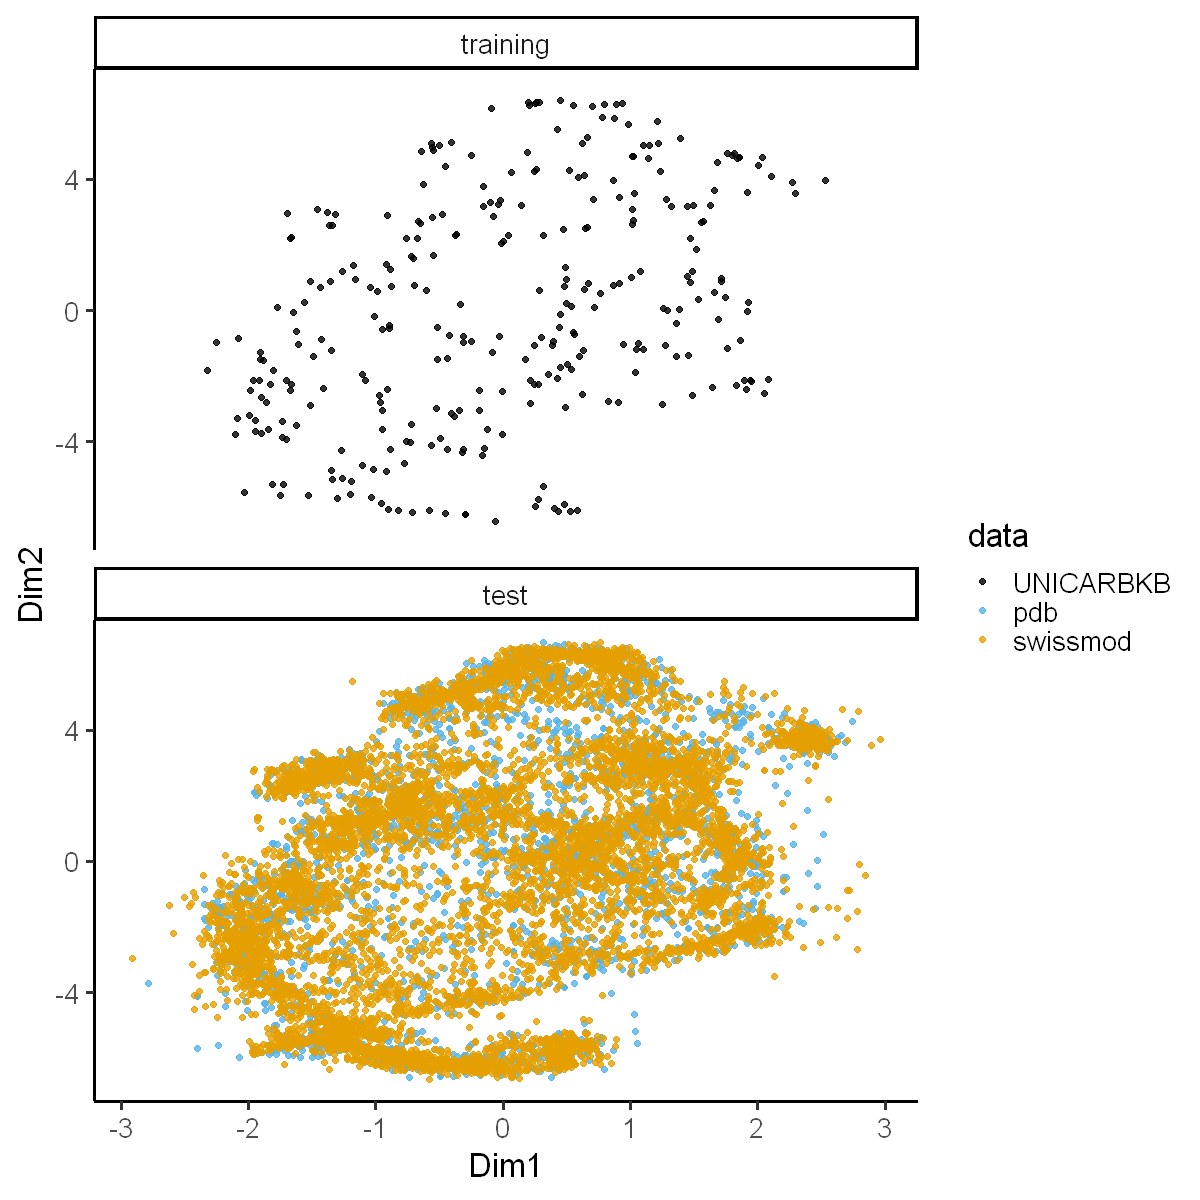

In [23]:
options(repr.plot.width=10,repr.plot.height=10)
dfi=df2 %>%
    mutate( training = factor(
        if_else(data=='UNICARBKB','training',
                if_else(grepl('UNICARBKB',data),
                        'near-training','test')),
        levels=c('training','near-training','test'))) %>% 
    filter( training!='near-training' & !data%in%c('FLU','HIV'))
dfi%>%
ggplot(aes(x=Dim1,y=Dim2,color=data))+
    scale_shape_manual(values = c(15,16,17,18,15,16,17))+
    # scale_color_viridis_d()+
    # scale_color_brewer('Dark1')+
    scale_color_manual(values=c('black', "#56B4E9","#E69F00"))+
    geom_point(alpha=.8)+
    facet_wrap(~training,nrow=2)+
    theme_classic(base_size = 20)
ggsave("figures/database_coverage/02d_UMAP.pdf",height = 15,width=8)
write.csv(dfi,"figures/database_coverage/02d_UMAP.csv")

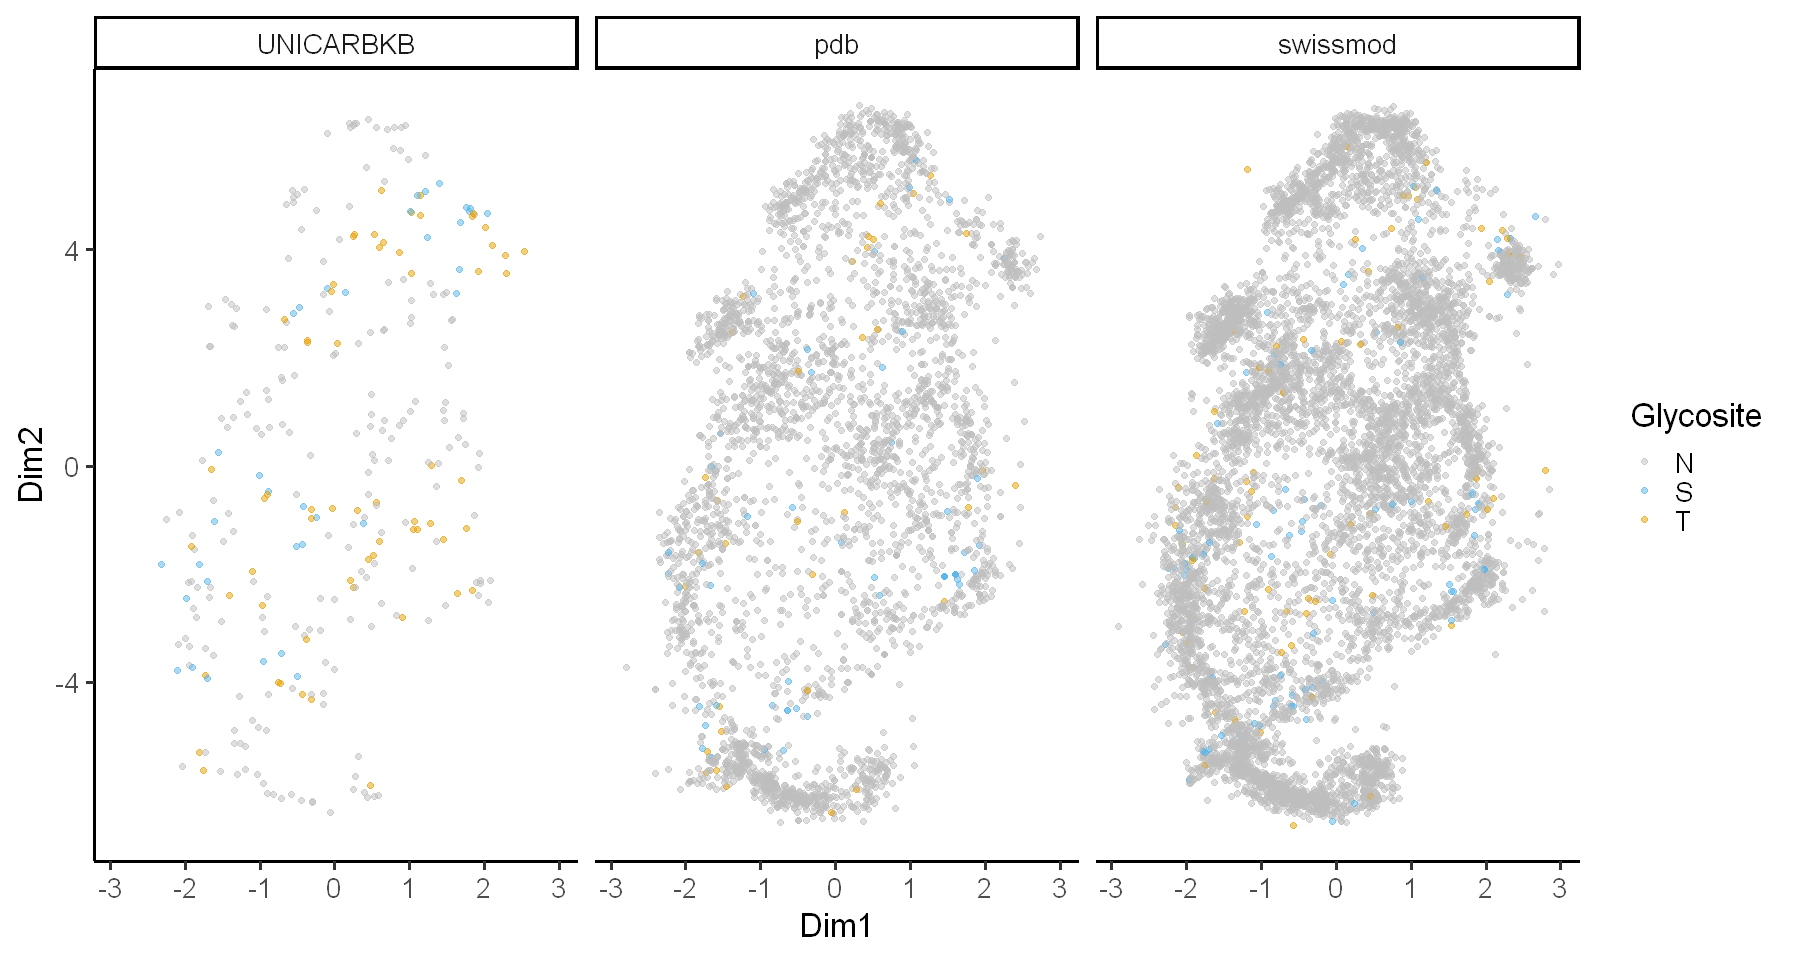

In [24]:
options(repr.plot.width=15,repr.plot.height=8)
dfi=df2 %>% filter( Glycosite %in% c('N','S','T')) %>%
    mutate( training = factor(
        if_else(data=='UNICARBKB','training',
                if_else(grepl('UNICARBKB',data),
                        'near-training','test')),
        levels=c('training','near-training','test'))) %>% 
    filter( training!='near-training' & !data%in%c('FLU','HIV'))
ggplot(dfi,aes(x=Dim1,y=Dim2,color=Glycosite))+
    scale_shape_manual(values = c(15,16,17,18,15,16,17))+
    # scale_color_viridis_d()+
    # scale_color_brewer('Dark1')+
    scale_color_manual(values=c('grey', "#56B4E9","#E69F00"))+
    geom_point(alpha=.5)+
    facet_grid(~data)+
    theme_classic(base_size = 20)
ggsave("figures/database_coverage/02d_UMAP.glycosite.pdf",height = 8,width=15)
write.csv(dfi,"figures/database_coverage/02d_UMAP.glycosite.csv")

In [25]:

p_l=apply(na.omit(df2[,2:3]),1,function(x){
	pmvnorm(lower=-Inf, upper=x, mean=c(0,0), #colMeans(df[df$data=='UNICARBKB',2:3]),
        corr=NULL, sigma=cov(df2[df2$data=='UNICARBKB',2:3])) })
p_h=apply(na.omit(df2[,2:3]),1,function(x){
	pmvnorm(lower=x, upper=Inf, mean=c(0,0), #colMeans(df[df$data=='UNICARBKB',2:3]),
        corr=NULL, sigma=cov(df2[df2$data=='UNICARBKB',2:3])) })


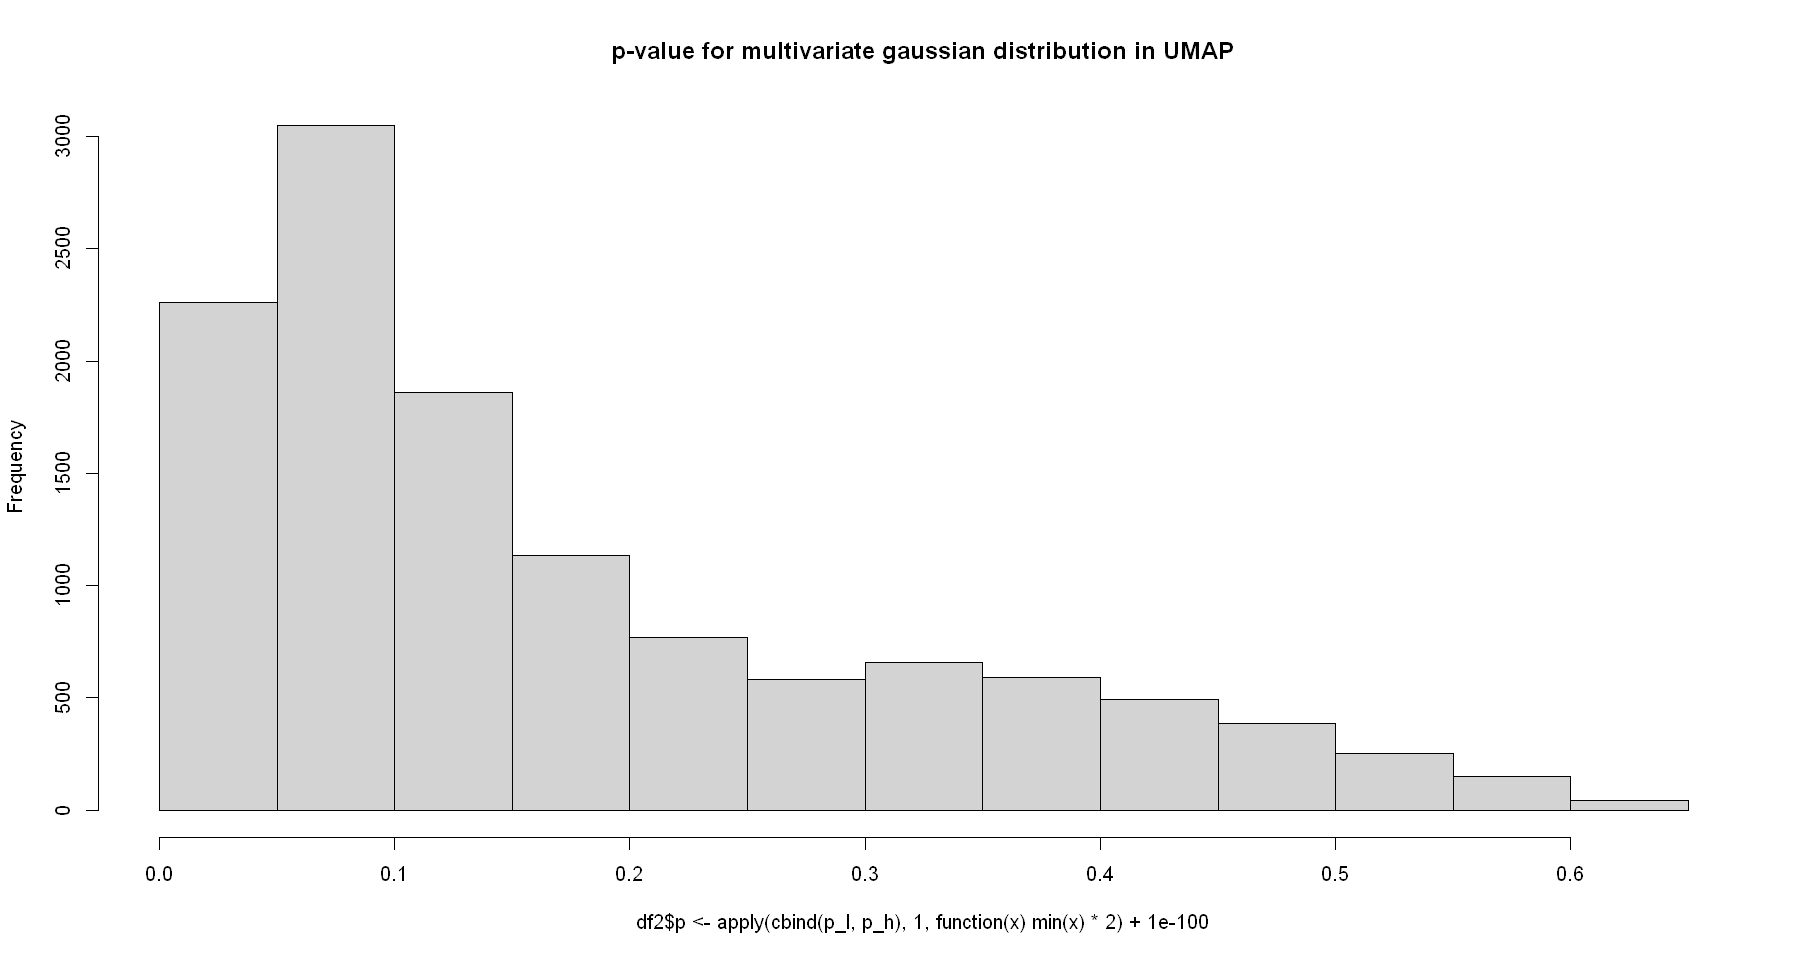

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 23 rows containing missing values or values outside the scale range (`geom_bar()`)."


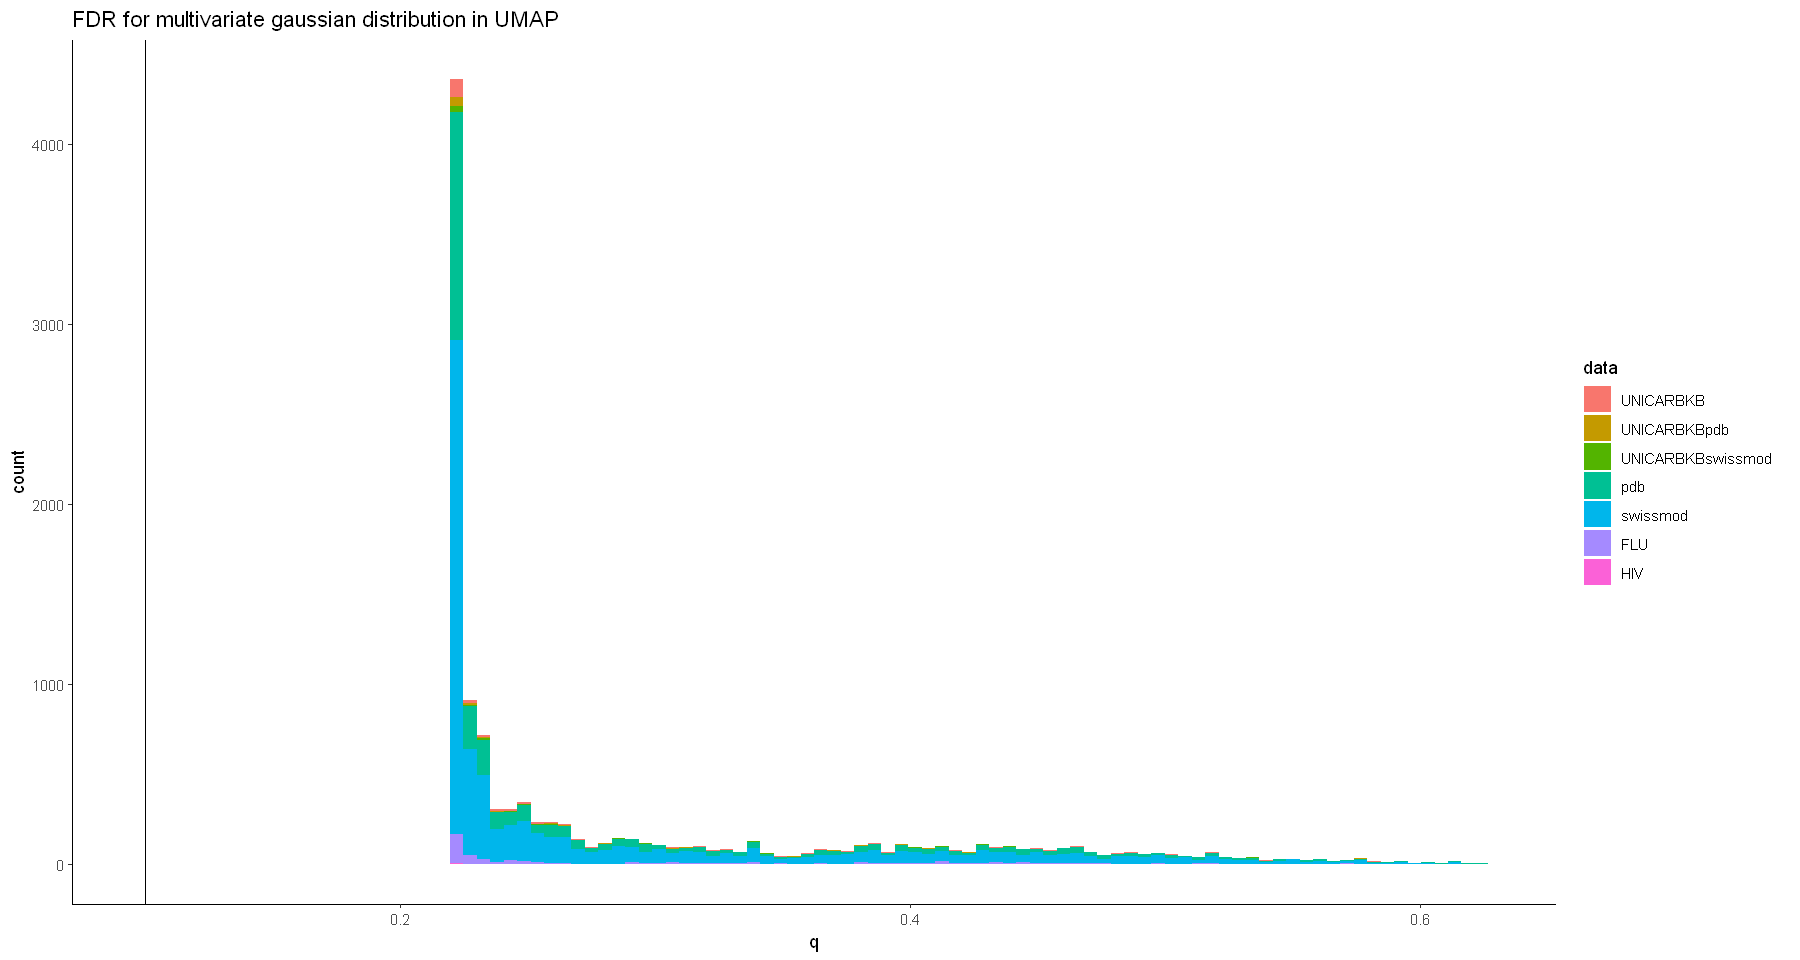

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 23 rows containing missing values or values outside the scale range (`geom_bar()`)."


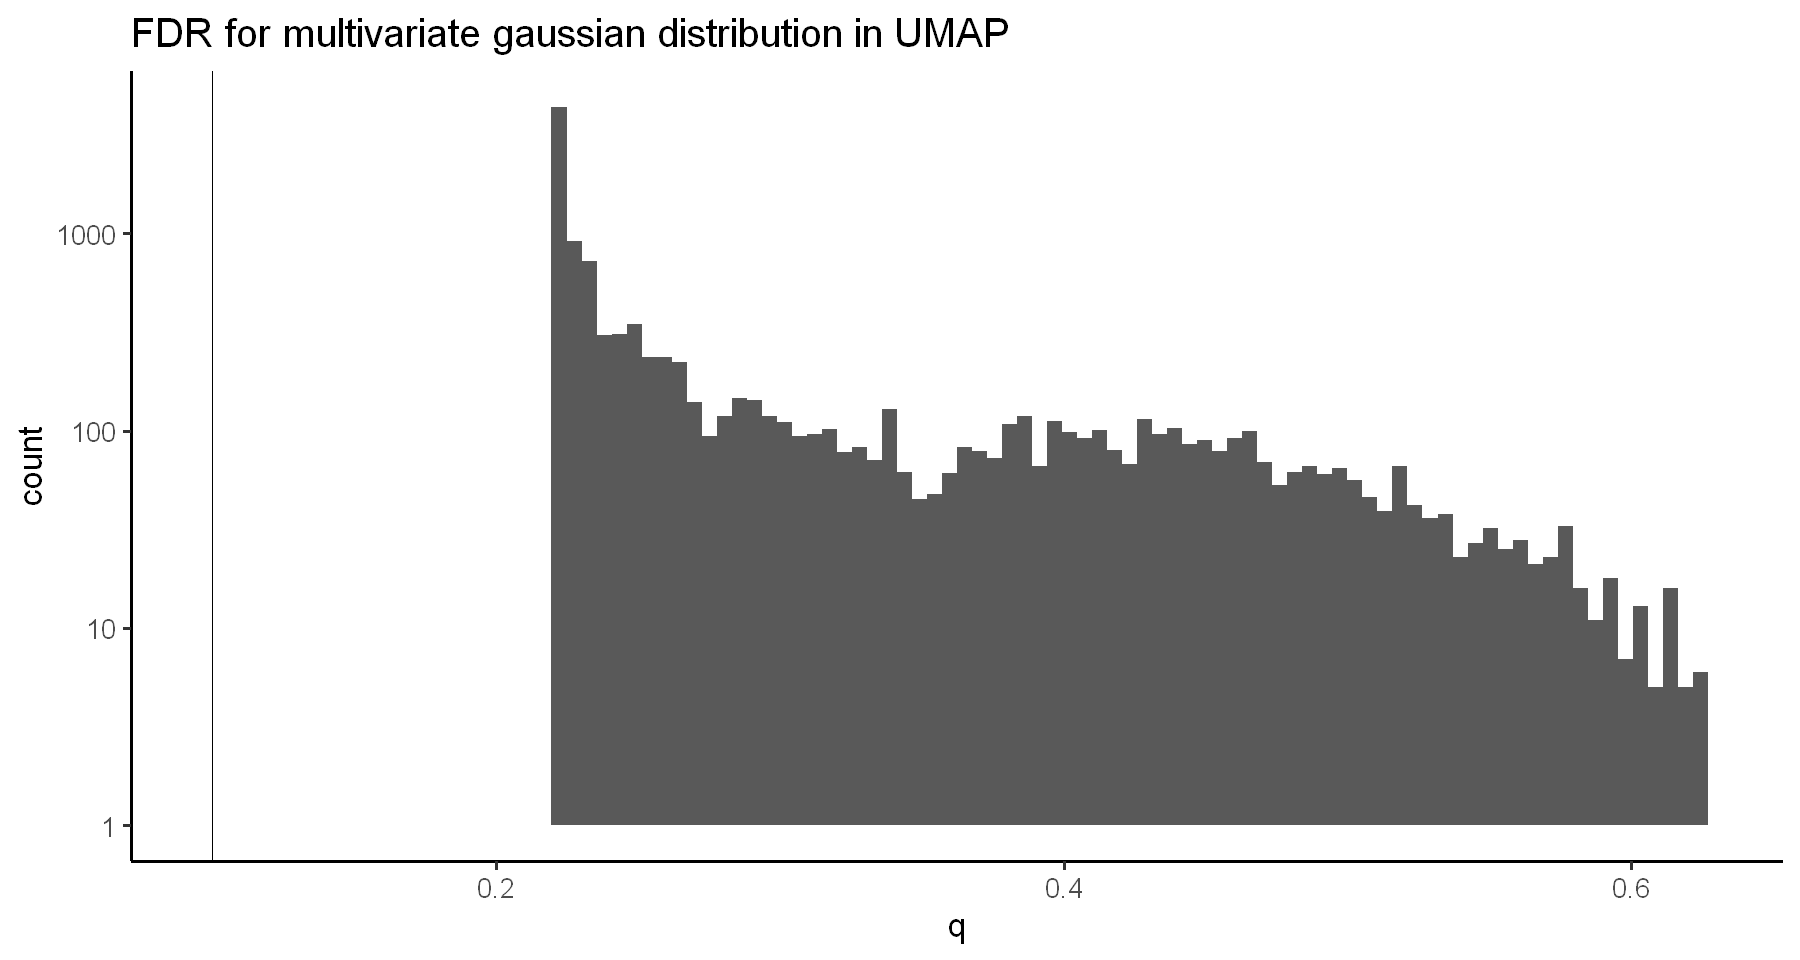

In [26]:
hist(df2$p<-apply(cbind(p_l,p_h),1,function(x) min(x)*2)+1e-100,main='p-value for multivariate gaussian distribution in UMAP')
#hist(df2$q<-p.adjust(df2$p,'fdr'),main='FDR for multivariate gaussian distribution in UMAP')
df2$q<-p.adjust(df2$p,'fdr')
ggplot(df2,aes(x=q,fill=data))+geom_histogram(bins=100)+#scale_y_log10()+
                 geom_vline(xintercept=.1)+theme_classic()+
                 ggtitle('FDR for multivariate gaussian distribution in UMAP')
ggsave('figures/database_coverage/02d_UMAP.fdr.split.pdf',width=10,height=10)

ggplot(df2,aes(x=q))+geom_histogram(bins=100)+scale_y_log10()+
                 geom_vline(xintercept=.1)+theme_classic(base_size = 20)+
                 ggtitle('FDR for multivariate gaussian distribution in UMAP')
ggsave('figures/database_coverage/02d_UMAP.fdr.pdf',width=10,height=10)

write.csv(df2,'figures/database_coverage/02d_UMAP.fdr.csv')



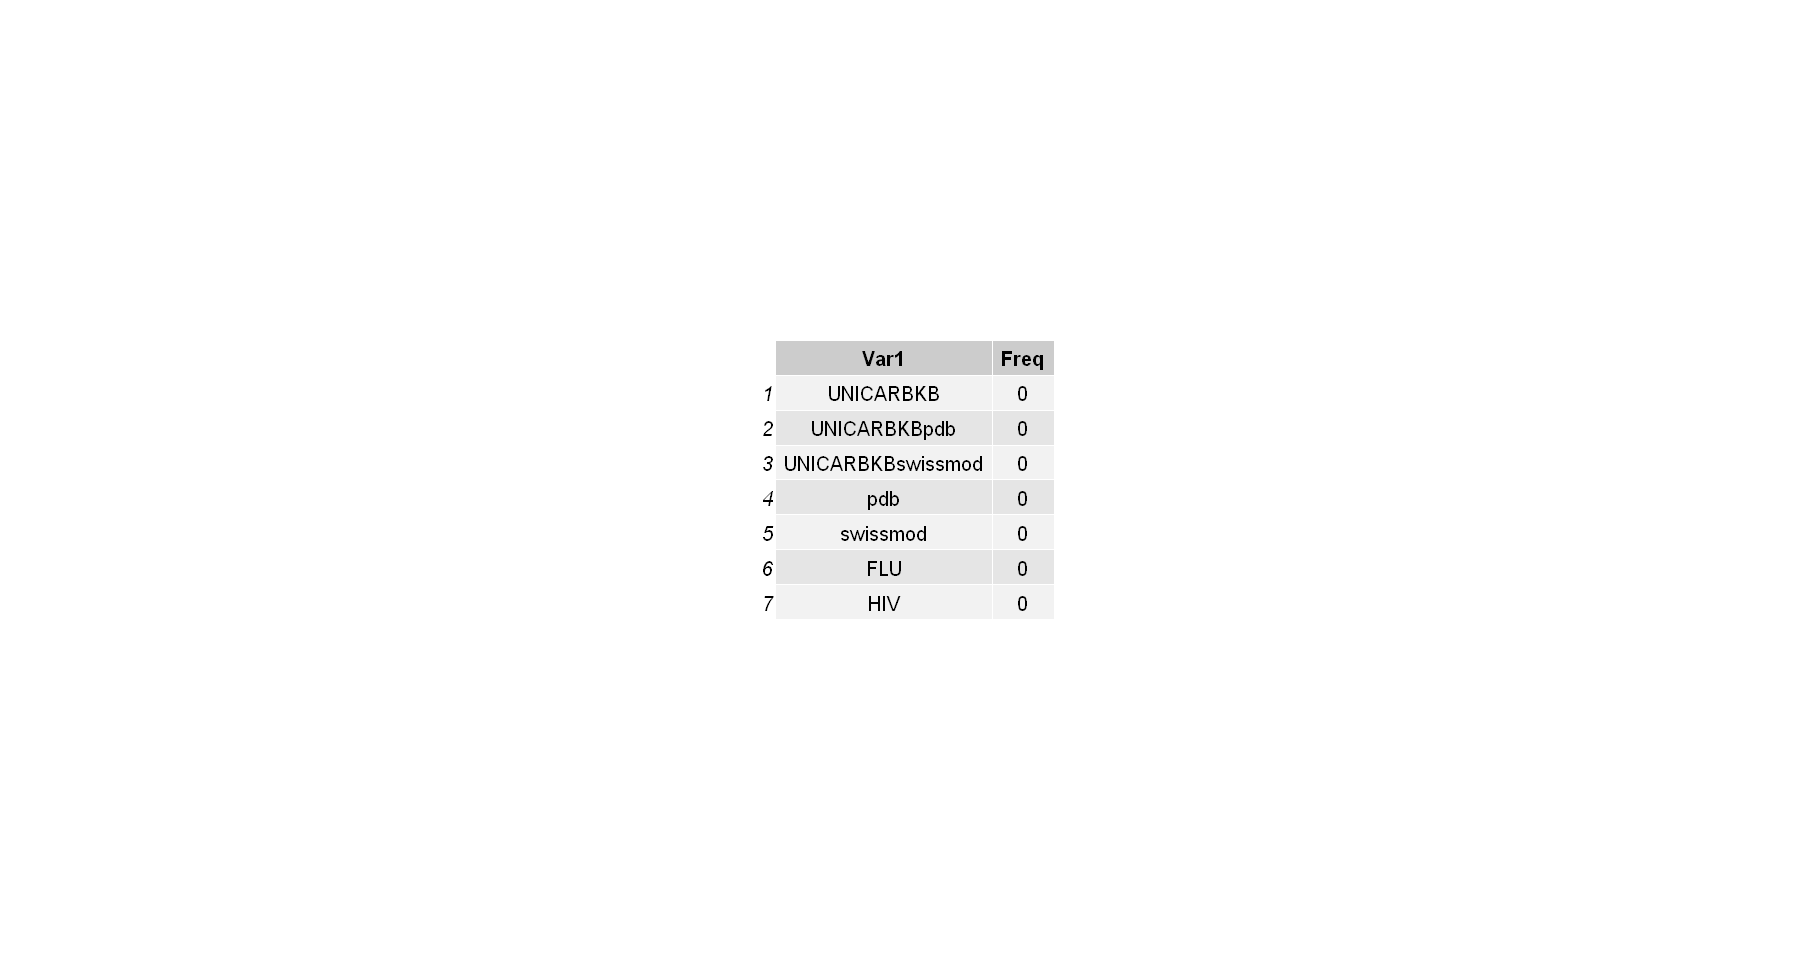

In [27]:
grid.table(data.frame(table(df2[df2$q<.1,1])))